In [1]:
import cv2
import numpy as np
import math
import imutils
from matplotlib import pyplot as plt
from ponyslayer.utils import imshow, imshows, imdraw, imdraws, imdraws_color, immask, immasks, implot, imsave
from ponyslayer import unicorn, transform

In [2]:
image_resolution = 800 # [pixel] Image ratio can be only 1:1 (square)
image_size = 400 # [mm.]
marker_size = 60 # [mm.]
marker_size_error = 0.1 # [ratio] Allowable card size error
min_path_length = 30 # [mm.]
max_path_length = 999 # [mm.]
min_path_width = 5 # [mm.]
max_path_width = marker_size + (marker_size*marker_size_error) # [mm.]
gradient_crop_ratio = 0.9 # Exclude both end (prevent too width range from noise)
min_height = 10
max_height = 20
min_intensity_range = 15 # ช่วงของ intensity ที่แคบที่สุดที่ยังถือว่าเป็น gradient

# Filter Setup

In [3]:
UnsharpMaskBeforeFindMarker = True
BlurKernelSize = (5, 5)

# Load Image

In [4]:
# frame = cv2.imread("Picture3.jpg")
frame = cv2.imread("Real4.jpg")
# frame = cv2.imread("./img/test/2.jpg")
frame = imutils.resize(frame, height=image_resolution, width = image_resolution)
frame = unicorn.padding_image(frame, 255)
print(frame.shape)
original = frame.copy()


(809, 809, 3)


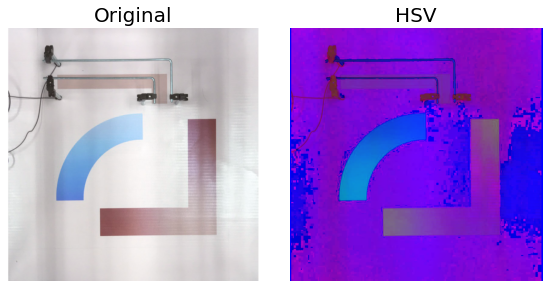

In [5]:
HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
imshows([original, HSV], ["Original", 'HSV'])
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame = cv2.medianBlur(frame,5)
frame = cv2.bilateralFilter(frame,9,75,75)

# Filter
White = Low Saturation, Black = Low Value

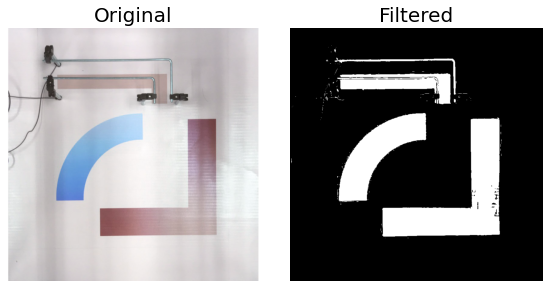

In [6]:
filter_lower = (0, 15, 100)
filter_max = (180, 255, 255)
filter_upper = (180, 255, 255)
filtered = cv2.inRange(HSV, filter_lower, filter_upper)
imshows([original, filtered], ["Original", "Filtered"])

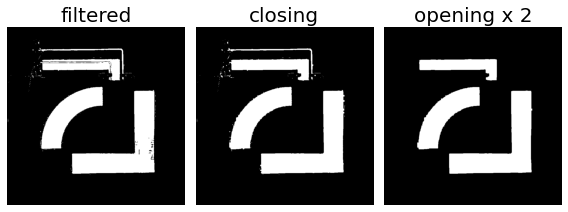

In [7]:
## Select Kernel Type ##
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5)) # cv2.MORPH_RECT = Rectangular Kernel, cv2.MORPH_ELLIPSE = Elliptical Kernel, cv2.MORPH_CROSSCross-shaped Kernel

closing = cv2.morphologyEx(filtered, cv2.MORPH_CLOSE, kernel)
opening_iteration = 2
erosion = cv2.erode(closing, kernel, iterations=opening_iteration)
dilation = cv2.dilate(erosion, kernel, iterations=opening_iteration)
imshows([filtered, closing, dilation], ["filtered", "closing", "opening x "+str(opening_iteration)])

Found 3 path.


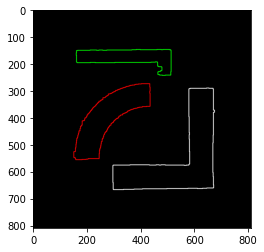

In [8]:
cnts_path, hierarchy_path = cv2.findContours(dilation,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) # ไม่ต้อง APPROX เพราะว่าจะเอามาหา path ต่อ
print("Found {} path.".format(len(cnts_path)))
canvas_path_raw = imdraws_color(cnts_path, frame, mode=1, size = 2, show = False)
imsave(canvas_path_raw, "contour")

In [ ]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang
for cnt in cnts_marker:
    max_cos = np.max([getAngle(cnt[i][0], cnt[(i+1) % 4][0], cnt[(i+2) % 4][0] ) for i in range(4)])
    print(max_cos)